In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

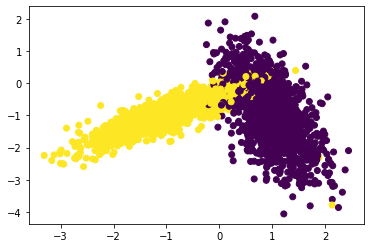

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [111]:
def split_train_K(xtrain,ytrain,folds):
    groups,group_labels = [],[]
    num_of_groups = int(len(xtrain)/folds)
    index = 0
    while index<len(xtrain):
        groups.append(xtrain[index:num_of_groups])
        group_labels.append(ytrain[index:num_of_groups])
        index = num_of_groups
        num_of_groups += int(len(xtrain)/folds)
    return groups,group_labels

def getParams(param_range):
    #get 10 unique values for params from the param_range
    set_param = set()
    if param_range[0] < param_range[1] and (param_range[1]-param_range[0] >= 10):
        while len(set_param) < 10:
            unique_value = np.random.uniform(param_range[0],param_range[1])
            set_param.add(int(unique_value))
    else:
        print("param_range Error: tuple must be (a,b) where a < b and (b-a) must be at least 10")
        
    #initialize params
    return sorted(set_param)


def RandomSearchCV(x_train,y_train,classifier, param_range, folds):

    params = getParams(param_range)
    print(params)
    
    #separate x_train and y_train into k groups
    groups,group_labels = split_train_K(x_train, y_train, folds)
    
    trainscores = []
    testscores  = [] 
    
    for param in tqdm(params):
        trainscores_folds = []
        testscores_folds  = []
        #print("parameter ="+str(param))
        #print("---"*10)
        for subgroup,sublabel in zip(reversed(groups),reversed(group_labels)):
            xtest = subgroup
            ytest = sublabel
            #print(subgroup)
            #print(sublabel)
            xtrain = [train for train in groups if train is not subgroup]
            ytrain = [x for x in group_labels if x is not sublabel]
            #print("ytraining = "+str(ytrain))
            xtrain = [j for sublist in xtrain for j in sublist]
            #print("xtraining = "+str(xtrain))
            ytrain = [j for sublist in ytrain for j in sublist]


            #print("###"*10)
        
            classifier.n_neighbors = param
            classifier.fit(xtrain,ytrain)
            
            Y_predicted = classifier.predict(xtest)
            testscores_folds.append(accuracy_score(ytest, Y_predicted))

            Y_predicted = classifier.predict(xtrain)
            trainscores_folds.append(accuracy_score(ytrain, Y_predicted))
            
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
    return trainscores,testscores,params
    
    
                          

  0%|          | 0/10 [00:00<?, ?it/s]

[6, 7, 11, 20, 26, 30, 31, 38, 45, 49]


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


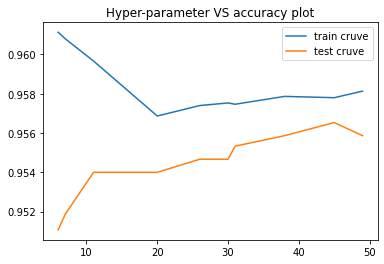

In [112]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

neigh = KNeighborsClassifier()
trainscores,testscores,params = RandomSearchCV(X_train, y_train, neigh, (1,50), 3)
plt.plot(params,trainscores, label='train cruve')
plt.plot(params,testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

From the plot above, we can see that the best K is when K =  45. Thus, let's train our KNN model with K=45 and plot the decision boundary

In [113]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

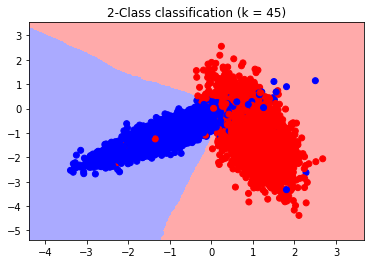

In [115]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 45)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)